In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy
import emcee
import corner

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [5]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [6]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

148114320263.0 m
0.9900830778535941 AU
149597870700.0


In [7]:
# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
metadata = metadata[postCommissioningMask]

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [8]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
     ...        ...      ...    ...         ...
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456645.083
heaterOn 2014/06/13    03:05  253.0 2456821.628
heaterOn 2014/12/11    13:00  199.0 2457

In [9]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


In [10]:
# Eliminate all data points that fall near "snow" events, as identified by convolving the f304/fSEM time series with a pointy filter
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    if t == 2452941:
        nearSnowMask = (ts >= t-5) & (ts <= t+15)
    else:
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True


In [11]:
# Eliminate all data points where flux is nan or zero
noFlux = np.zeros_like(ts).astype(bool)

nanFluxMask = (np.isnan(fs) | np.isnan(us) | (fs==0) | (us==0))
noFlux[nanFluxMask] = True


# load SEM

In [12]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# load SORCE

In [13]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_171_unc[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_195_unc[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_284_unc[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_304_unc[arb.units]', 'transmitted_flux_sumEITBands[arb.units]', 'transmitted_flux_sumEITBands_unc[arb.units]']
2452696.0
2458904.0


# load VIRGO

In [14]:
VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382           0.133
2450196.0    1360.361           0.136
2450197.0    1360.343           0.132
2450198.0    1360.372           0.137
2450199.0    1360.388           0.131
2450200.0    1360.421           0.137
2450201.0    1360.441           0.132
2450202.0    1360.478           0.136
      ...         ...             ...
2460250.0    1362.126           0.141
2460251.0    1362.337           0.147
2460252.0    1362.256           0.148
2460253.0    1362.128           0.141
2460254.0    1361.907           0.144
2460255.0    1361.639           0.144
2460256.0    1361.522           0.147
2460257.0    1361.627           0.168
2460258.0    1361.731           0.179
2460259.0    1361.783           0.153
2460260.0   

# Arrays to work with

In [15]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

wmask_304 = wmasks[0] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes & ~withinBakeout & ~nearSnow & ~noFlux
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])
#fSEM = np.array(SEM['centralOrderFlux[counts/s]'])
#uSEM = np.array(SEM['centralOrderFluxUnc[counts/s]'])


tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
uSORCE = np.array(SORCE['transmitted_flux_sumEITBands_unc[arb.units]'])

tVIRGO = np.array(VIRGO['t_obs[JD]'])
fVIRGO = np.array(VIRGO['flux[W/m^2]'])
uVIRGO = np.array(VIRGO['flux_unc[W/m^2]'])

# Use the ratio of flux in the EIT 304 band to flux in the SEM narrow band to correct for instrumental effects, inc. bakeouts

In [16]:
def least_squares_line(X,Y,Yerr):
    """
    Solve the normal equation B = (X.T*C.inv*X).inv*X.T*C.inv*Y
    Inputs:
    X = matrix of x values
    bOOT = integer best BIC polynomial OOT order
    Y = vector of y values
    Yerr = vector of yerr values
    Outputs:
    B = vector of model parameters that minimizes chi^2
    Bunc = analytic uncertainties on those parameters (see e.g. )
    """
    # least squares params
    Xmat = np.vander(X, 2)
    
    XTX = np.dot(Xmat.T, Xmat/Yerr[:, None]**2)
    
    B = np.linalg.solve(XTX, np.dot(Xmat.T, Y/Yerr**2))


    #uncertainties on least squares params
    N = len(Y)

    prefac = 1./(np.sum(1./Yerr**2)*np.sum(X**2/Yerr**2) - (np.sum(X/Yerr**2)**2))
    intercept_unc = np.sum( ((prefac/Yerr**2)*(np.sum(X**2/Yerr**2) - X*np.sum(X/Yerr**2)))**2 * Yerr**2)
    slope_unc =     np.sum( ((prefac/Yerr**2)*(-np.sum(X/Yerr**2)   + X*np.sum(1/Yerr**2)))**2 * Yerr**2)

    Bvar = np.array((slope_unc, intercept_unc))
    
    return B, Bvar

## First, correct decaying exponential behavior after Jan 11, 2012 = JD 2455938.417

In [17]:
def linearInterpolationWithUncertainty(t_new, t_orig, f_orig, u_orig):
    f_new = np.interp(t_new, t_orig, f_orig)

    # the below analytic uncertainty propagation was tending to underestimate the neighboring uncertainties
    """
    u_new = np.zeros_like(f_new).astype(float)
    
    for i in range(len(f_new)):
        t_now = t_new[i]
        t_prev = t_orig[t_orig <= t_now][-1]
        f_prev = f_orig[t_orig <= t_now][-1]
        u_prev = u_orig[t_orig <= t_now][-1]
        t_next = t_orig[t_orig > t_now][0]
        f_next = f_orig[t_orig > t_now][0]
        u_next = u_orig[t_orig > t_now][0]

        print("")
        print(u_prev)
        u_now = np.sqrt( ( ((t_next - t_now)/(t_next - t_prev)) * u_prev)**2 + ( ((t_now - t_prev)/(t_next - t_prev)) * u_next)**2 )
        print(u_now)
        print(u_next)

        print((t_next-t_now)/(t_next-t_prev))
        print((t_now-t_prev)/(t_next-t_prev))
        u_new[i] = u_now
    """
    #so instead, more simply:
    u_new = np.median(u_orig)*np.ones_like(f_new)
    
    return f_new, u_new

In [18]:
print(len(f304))
print(len(fSEM))

print(len(f304[np.isnan(u304)]))
# SEM has many fewer data points than EIT, so I should interpolate EIT to lie on tSEM and then do my fitting that way

22158
10160
0


98834.85371975851


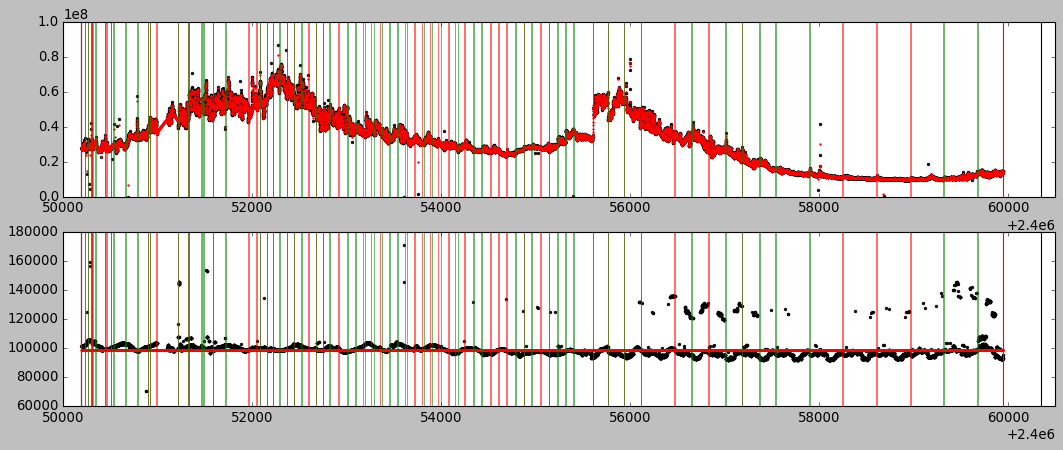

In [19]:
#cut off beginning and end of time series, when SEM is taking data but EIT is not
t304_mask = (tSEM >= t304[0]) & (tSEM <= t304[-1])

f304_tSEM, u304_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304, u_orig=u304)
print(np.min(u304_tSEM))
fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(t304, f304, 'k.',ms=5)
axes[0].plot(tSEM[t304_mask], f304_tSEM, 'r.',ms=3)
axes[0].set_ylim(0,1.e8)

axes[1].plot(t304, u304, 'k.',ms=5)
axes[1].plot(tSEM[t304_mask], u304_tSEM, 'r.',ms=3)
#axes[1].set_ylim(-10000,1.8e5)
axes[1].set_xlim(2450000,2452000)
for ax in axes:
    ax.set_xlim(2450000,2460500)
    ax.axvline(tSEM[0], color='k')
    ax.axvline(tSEM[-1], color='k')

    ax.axvline(t304[0], color='r')
    ax.axvline(t304[-1], color='r')
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

plt.show()

# define ratio

In [20]:
def normalizedFluxRatio(f1, f2, u1, u2):
    """
    assume f1, f2 are defined on the same array of times and therefore have the same length
    """

    med_f1 = np.median(f1[~np.isnan(f1)])
    med_f2 = np.median(f2[~np.isnan(f2)])

    ratio = (f1/med_f1)/(f2/med_f2)

    unc_med_f1 = np.sqrt((np.pi/2) * np.sum(u1[~np.isnan(u1)]**2/len(u1[~np.isnan(u1)])))
    unc_med_f2 = np.sqrt((np.pi/2) * np.sum(u2[~np.isnan(u2)]**2/len(u2[~np.isnan(u2)])))

    unc_ratio_sq = ((med_f2/(f2 * med_f1))**2 * u1**2) + (((f1*med_f2)/med_f1)**2 * (1/f2**2)**2 * u2**2) + (((f1*med_f2)/f2)**2 * (1/med_f1**2)**2 * unc_med_f1**2) + ((f1/(f2 * med_f1))**2 * unc_med_f2**2)
    unc_ratio = np.sqrt(unc_ratio_sq)

    return ratio, unc_ratio

In [21]:
ratio, unc_ratio = normalizedFluxRatio(f1=f304_tSEM, f2=fSEM[t304_mask], u1=u304_tSEM, u2=uSEM[t304_mask])

In [22]:
# fit two exponentials: one between these two bakeouts (this, June 3, 2016, is the time at which bakeout frequency goes from
# ~every 6 months to ~every year)
fit1Mask = (tSEM[t304_mask] >= 2455938.417) & (tSEM[t304_mask] < 2457542.583333)
# and one for the end
fit2Mask = (tSEM[t304_mask] >= 2457542.583333)

# we're fitting a line to ln(ratio) vs. t
# so need to transform coordinates and uncertainties
t1_to_fit = tSEM[t304_mask][fit1Mask] - tSEM[t304_mask][fit1Mask][0]
lnratio1_to_fit = np.log(ratio[fit1Mask])
lnratio1_to_fit_err = (unc_ratio/ratio)[fit1Mask]

noNans1 = ~np.isnan(t1_to_fit) & ~np.isnan(lnratio1_to_fit) & ~np.isnan(lnratio1_to_fit_err)

#fit the line
B1, B1var = least_squares_line(X=t1_to_fit[noNans1],Y=lnratio1_to_fit[noNans1],Yerr=lnratio1_to_fit_err[noNans1])
print(B1)
#print(np.sqrt(B1var))

# transform coordinates and uncertainties for the second exponential
t2_to_fit = tSEM[t304_mask][fit2Mask] - tSEM[t304_mask][fit2Mask][0]
lnratio2_to_fit = np.log(ratio[fit2Mask])
lnratio2_to_fit_err = (unc_ratio/ratio)[fit2Mask]

noNans2 = ~np.isnan(t2_to_fit) & ~np.isnan(lnratio2_to_fit) & ~np.isnan(lnratio2_to_fit_err)

B2, B2var = least_squares_line(X=t2_to_fit[noNans2],Y=lnratio2_to_fit[noNans2],Yerr=lnratio2_to_fit_err[noNans2])
print(B2)
#print(np.sqrt(B2var))


[-0.00059312  0.37070747]
[-1.06756448e-04 -5.54992257e-01]


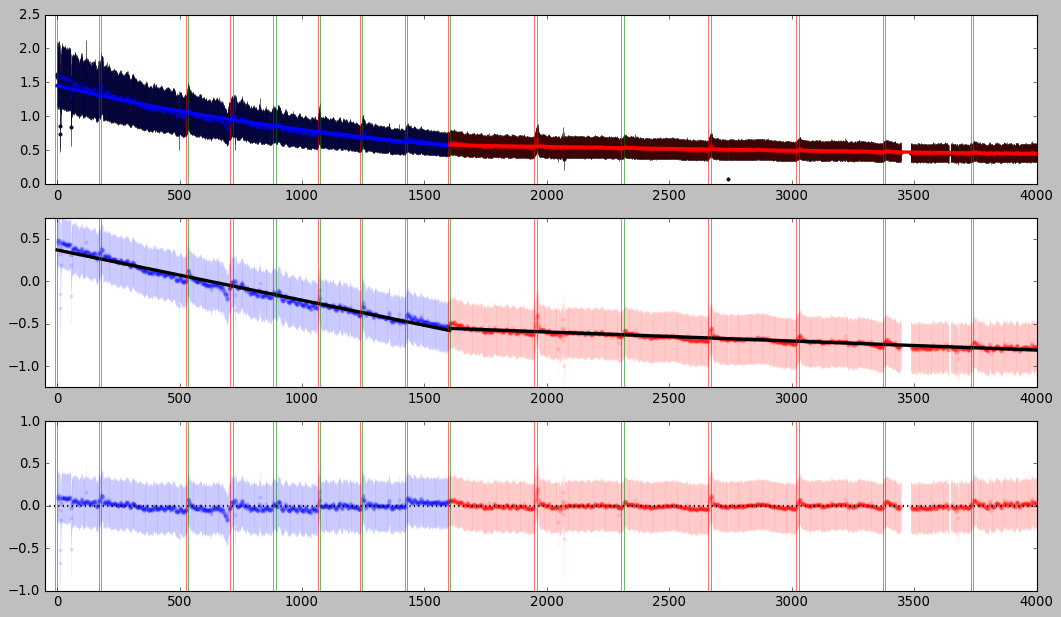

In [23]:
fig, axes = plt.subplots(3,1,figsize=(16,9))
axes[0].errorbar(tSEM[t304_mask][fit1Mask | fit2Mask] - tSEM[t304_mask][fit1Mask][0], ratio[fit1Mask | fit2Mask],yerr=unc_ratio[fit1Mask | fit2Mask],marker='.',color='k',elinewidth=0.5,capsize=0,linestyle='None',zorder=1)
axes[0].errorbar(t1_to_fit, ratio[fit1Mask],yerr=unc_ratio[fit1Mask],marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)
axes[0].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], ratio[fit2Mask],yerr=unc_ratio[fit2Mask],marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=2,alpha=0.1)

axes[0].plot(t1_to_fit, np.exp(B1[0]*t1_to_fit + B1[1]),'b-',lw=3,zorder=3)
axes[0].plot(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], np.exp(B2[0]*t2_to_fit + B2[1]),'r-',lw=3,zorder=3)

axes[1].errorbar(t1_to_fit, lnratio1_to_fit,yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t1_to_fit, B1[0]*t1_to_fit + B1[1], 'k-',lw=3,zorder=2)
axes[1].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], lnratio2_to_fit,yerr=lnratio2_to_fit_err,marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[1].plot(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], B2[0]*t2_to_fit + B2[1], 'k-',lw=3,zorder=2)
axes[1].set_ylim(-1.25,0.75)

axes[2].errorbar(t1_to_fit, lnratio1_to_fit - (B1[0]*t1_to_fit + B1[1]), yerr=lnratio1_to_fit_err,marker='.',color='b',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].errorbar(t2_to_fit + tSEM[t304_mask][fit2Mask][0] - tSEM[t304_mask][fit1Mask][0], lnratio2_to_fit - (B2[0]*t2_to_fit + B2[1]),yerr=lnratio2_to_fit_err, marker='.',color='r',elinewidth=0.5,capsize=0,linestyle='None',zorder=1,alpha=0.1)
axes[2].axhline(0,color='k',ls=':',zorder=3,lw=2)
axes[2].set_ylim(-1,1)


for ax in axes:
    ax.set_xlim(-50,4000)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate- tSEM[t304_mask][fit1Mask][0],color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate- tSEM[t304_mask][fit1Mask][0],color='g',linestyle='-',lw=0.5)

plt.show()

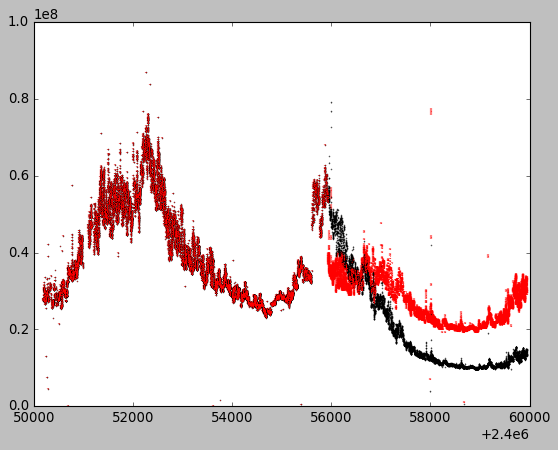

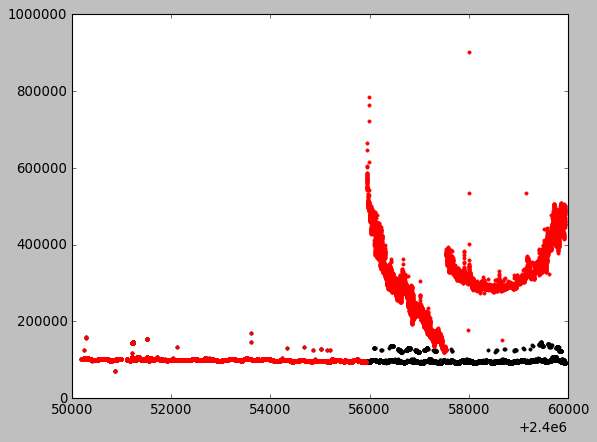

In [24]:
# new arrays to work with
f304_expCorrected = copy.deepcopy(f304)
u304_expCorrected = copy.deepcopy(u304)

# fit parameters, re-notated
A1 = np.exp(B1[1])
# note that sigma_A = dA/dB1 * sigma_B1 = exp(B1) * sigma_B1
sigma_A1 = np.exp(B1[1]) * np.sqrt(B1var[1])
k1 = B1[0]
sigma_k1 = np.sqrt(B1var[0])

A2 = np.exp(B2[1])
sigma_A2 = np.exp(B2[1]) * np.sqrt(B2var[1])
k2 = B2[0]
sigma_k2 = np.sqrt(B2var[0])

#redefine fit masks to apply to t304 so we can do the correction
fit1Mask_t304 = (t304 >= 2455938.417) & (t304 < 2457542.583333)
fit2Mask_t304 = (t304 >= 2457542.583333)
t1_to_fit_t304 = t304[fit1Mask_t304] - t304[fit1Mask_t304][0]
t2_to_fit_t304 = t304[fit2Mask_t304] - t304[fit2Mask_t304][0]

# f304,corr = f304/(A*exp(-kt)) = f304 * (1/A) * exp(kt), where A = exp(B[1]) and k = -B[0]
f304_expCorrected[fit1Mask_t304] = f304[fit1Mask_t304]/(A1* np.exp(k1*t1_to_fit_t304))
f304_expCorrected[fit2Mask_t304] = f304[fit2Mask_t304]/(A2* np.exp(k2*t2_to_fit_t304))

# propagate uncertainties analytically
u304_expCorrected[fit1Mask_t304] = np.sqrt( ( (np.exp(k1*t1_to_fit_t304)/A1) * u304[fit1Mask_t304] )**2 + ( ((f304[fit1Mask_t304] * np.exp(k1*t1_to_fit_t304))/A1**2) * sigma_A1 )**2 + ( ((f304[fit1Mask_t304] * np.exp(k1*t1_to_fit_t304) * t1_to_fit_t304)/A1) * sigma_k1 )**2 )
u304_expCorrected[fit2Mask_t304] = np.sqrt( ( (np.exp(k2*t2_to_fit_t304)/A2) * u304[fit2Mask_t304] )**2 + ( ((f304[fit2Mask_t304] * np.exp(k2*t2_to_fit_t304))/A2**2) * sigma_A2 )**2 + ( ((f304[fit2Mask_t304] * np.exp(k2*t2_to_fit_t304) * t2_to_fit_t304)/A2) * sigma_k2 )**2 )

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(t304, f304, u304, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_expCorrected, u304_expCorrected, color='r',marker='.',markersize=1,linestyle='None',elinewidth=2,capsize=0,alpha=0.5)
ax.set_ylim(0.,1e8)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(t304, u304, 'k.')
ax.plot(t304, u304_expCorrected, 'r.')
plt.show()


# redefine ratio

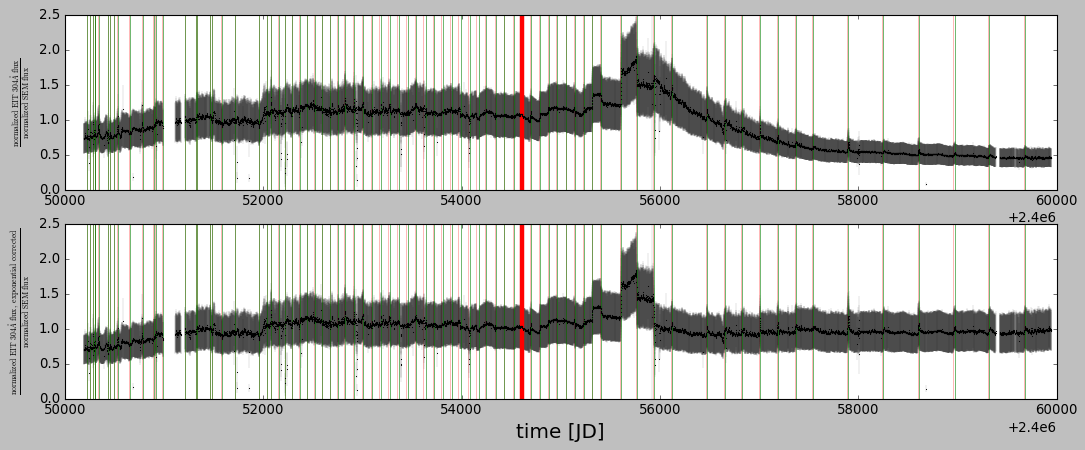

In [25]:
f304_expCorrected_tSEM, u304_expCorrected_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_expCorrected, u_orig=u304_expCorrected)
ratio_expCorrected, unc_ratio_expCorrected = normalizedFluxRatio(f1=f304_expCorrected_tSEM, f2=fSEM[t304_mask], u1=u304_expCorrected_tSEM, u2=uSEM[t304_mask])

fig, axes = plt.subplots(2,1,figsize=(16,6))

axes[0].errorbar(tSEM[t304_mask], ratio, yerr=unc_ratio, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)
axes[1].errorbar(tSEM[t304_mask], ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    for ax in axes:
        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)


axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ exponential\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_xlabel(r"time [JD]", fontsize=18)
for ax in axes:
    ax.set_ylim(0,2.5)
    ax.axvline(2454609.072650, color='r', lw=4)

plt.show()

# Now, for each inter-bakeout period, fit a linear relationship to the f304/fSEM ratio and divide it out of f304.

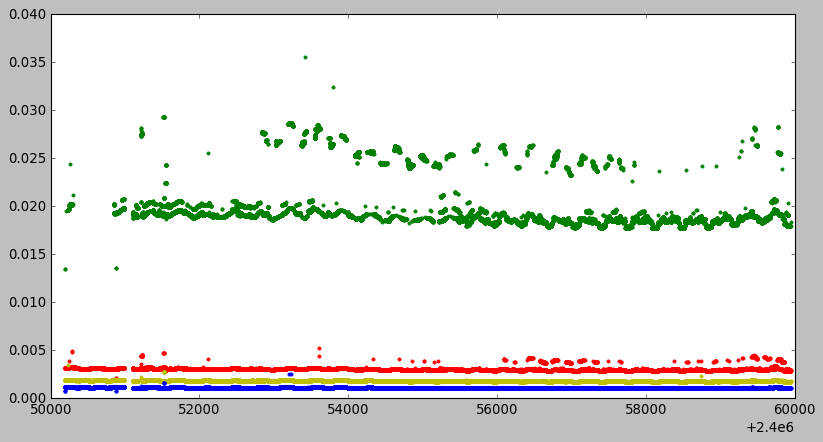

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(t304, u304/np.median(f304[~np.isnan(f304)]), 'r.')
ax.plot(t284, u284/np.median(f284[~np.isnan(f284)]), 'g.')
ax.plot(t195, u195/np.median(f195[~np.isnan(f195)]), 'y.')
ax.plot(t171, u171/np.median(f171[~np.isnan(f171)]), 'b.')
plt.show()

In [60]:
def fitBakeoutSegment(t, ratio, unc_ratio, prev_bakeoutEndDate, next_bakeoutStartDate):
    """
    Fit a line to the ratio of f304_norm/fSEM_norm
    """
    fitMask = (t >= prev_bakeoutEndDate) & (t <= next_bakeoutStartDate)

    t_to_fit = t[fitMask] - t[fitMask][0]
    ratio_to_fit = ratio[fitMask]
    unc_ratio_to_fit = unc_ratio[fitMask]

    noNans = ~np.isnan(t_to_fit) & ~np.isnan(ratio_to_fit) & ~np.isnan(unc_ratio_to_fit) 

    B, Bunc = least_squares_line(X=t_to_fit[noNans],Y=ratio_to_fit[noNans],Yerr=unc_ratio_to_fit[noNans])

    return fitMask, B, Bunc

def correctLinearBakeoutSegment(t, f, u, B, Bunc):
    """
    divide the linear relationship fit to f304_norm/fSEM_norm out of f304_norm
    """
    # fit parameters, re-notated
    m = B[0]
    sigma_m = np.sqrt(Bunc[0])
    b = B[1]
    sigma_b = np.sqrt(Bunc[1])

    #propagate uncertainties analytically
    fcorr = f/(m*t + b)
    ucorr = np.sqrt( ( (1./(m*t +b)) * u )**2 + ( (-f/(m*t + b)**2) * t * sigma_m )**2 + ( (-f/(m*t + b)**2) * sigma_b )**2 ) 

    return fcorr, ucorr


def fitparams_to_lineparams(fitparams):
    theta = fitparams[:,0]
    bcostheta = fitparams[:,1]
    scatter = fitparams[:,2]
    m = np.tan(theta)
    b = bcostheta/np.cos(theta)
    return np.vstack((m.T, b.T, scatter.T)).T

def lineparams_to_fitparams(lineparams):
    m = lineparams[:,0]
    b = lineparams[:,1]
    scatter = lineparams[:,2]
    theta = np.arctan2(m,1)
    bcostheta = b * np.cos(theta)
    return np.vstack((theta.T, bcostheta.T, scatter.T)).T

def log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds):
    """
    Inputs:
    fit parameters:
        theta = arctan(slope)
        b*cos(theta) = perpendicular distance from line to origin
    Returns:
    Log prior for these parameters
    """
    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]
    # theta prior is uniform from 0 to pi
    if theta < theta_bounds[0] or theta >= theta_bounds[1]:
        return -np.inf
    # b*cos(theta) prior is uniform 
    # recall that b*cos(theta) is the perpendicular distance of the line from the origin
    if bcostheta < bcostheta_bounds[0] or bcostheta > bcostheta_bounds[1]:
        return -np.inf

    # scatter prior is uniform
    if scatter < scatter_bounds[0] or scatter > scatter_bounds[1]:
        return -np.inf
    
    return -np.log(theta_bounds[1]-theta_bounds[0]) - np.log(bcostheta_bounds[1]-bcostheta_bounds[0]) - np.log(scatter_bounds[1]-scatter_bounds[0]) 


def log_likelihood(params, x, y, xerr, yerr, xycov=None):
    """
    following Hogg et al. 2010 chapter 7
    Assuming no covariance between data points (bad assumption)
    
    Inputs:
    theta, bcostheta = params at current MCMC step
    x, y, xerr, yerr = arrays of data
                
    Returns:
    Log likelihood calculated for these parameters.
    """

    theta = params[0]
    bcostheta = params[1]
    scatter = params[2]

    if scatter < 0:
        return -np.inf

    # orthogonal displacement of data points from the line parametrized by theta, bcostheta
    delta_arr = -np.sin(theta)*x + np.cos(theta)*y - bcostheta

    # projected covariance matrix 
    #(again assuming no off-diagonal terms)
    if xycov is None:
        xycov = np.zeros_like(x)
    sigma_sq = (np.sin(theta)**2 * xerr**2) - (2*np.sin(theta)*np.cos(theta)*xycov) + (np.cos(theta)**2 * yerr**2)
    '''
    if np.any(np.isnan(sigma_sq)) | np.any(np.isnan(scatter)) | np.any(np.isnan(np.log(sigma_sq+scatter))):
        print("term 1")
        print(-np.sum(0.5*np.log(sigma_sq+scatter)))
        print(np.log(sigma_sq+scatter))
        print(sigma_sq+scatter)
    
        print("term 2")
        print(-np.sum( delta_arr**2/(2*(sigma_sq+scatter)) ))
        print("")
    '''
    ll = -np.sum(0.5*np.log(sigma_sq+scatter)) - np.sum( delta_arr**2/(2*(sigma_sq+scatter)) )
    
    return ll

def log_posterior(params, x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds, samplefile=None, xycov=None):
    theta = params[0]
    bcostheta = params[1]
    
    if samplefile is not None:
        lineparams = fitparams_to_lineparams(params)
        samplef = open(samplefile, "w")
        samplef.write("{0} {1}\n".format(m, b))
        samplef.close()

    prior = log_prior(params, theta_bounds, bcostheta_bounds, scatter_bounds)
    if np.isfinite(prior) is False:
        return -np.inf
    
    likelihood = log_likelihood(params, x, y, xerr, yerr, xycov)
    if np.isfinite(likelihood) is False:
        return -np.inf

    return prior + likelihood


def initialize_walkers(nwalkers, init_theta=np.pi/2, init_bcostheta=0., init_scatter=5.):
    """
    Generates nwalkers random initial positions in ndim space.

    Inputs:
    nwalkers = number of initial positions to generate
    ndim = number of dimensions of parameter space
    init_m = initial guess at slope
    init_b = initial guess at intercept

    Returns:
    pos = array of initial walker positions of shape (nwalkers, ndim=2)
    """
    '''
    lower_prior_bounds = np.array((0, -1*bperp_prior))
    upper_prior_bounds = np.array((np.pi, bperp_prior))
    
    #randomly sampled from 10D box
    pos = np.random.uniform(low=0.01, high=0.99, size=(nwalkers, 2))
    pos = (pos*(upper_prior_bounds - lower_prior_bounds)) + lower_prior_bounds
    '''
    pos = np.zeros((nwalkers, 3))
    pos[:,0] = init_theta + 1.e-2*np.random.randn(nwalkers)
    pos[:,1] = init_bcostheta + 1.e-2*np.random.randn(nwalkers)
    pos[:,2] = init_scatter + 1.e-2*np.random.randn(nwalkers) 

    return pos

def fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(1.e-6, 100), nwalkers=10, nsteps=5000, discard=500, plot=False, prune_unconverged_walkers=False):
    init_guess = initialize_walkers(nwalkers=nwalkers)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=3, log_prob_fn=log_posterior, args=[x, y, xerr, yerr, theta_bounds, bcostheta_bounds, scatter_bounds])

    sampler.run_mcmc(init_guess, nsteps)
    samples = sampler.get_chain()

    labels = ['theta', 'bcostheta', 'scatter']
    linelabels=['m', 'b','scatter']
    
    if plot is True:
        fig, axes = plt.subplots(5,1,figsize=(16,6))
        for i in range(3):
            ax = axes[i]
            ax.plot(samples[:,:,i], 'k',alpha=0.3)
            ax.set_xlim(0,len(samples))
            ax.set_ylabel(labels[i])

        axes[3].plot(np.tan(samples[:,:,0]),'k',alpha=0.3)
        axes[3].set_xlim(0,len(samples))
        axes[3].set_ylabel('m')

        axes[4].plot(samples[:,:,1]/np.cos(samples[:,:,0]),'k',alpha=0.3)
        axes[4].set_xlim(0,len(samples))
        axes[4].set_ylabel('b')

        plt.show()

    if prune_unconverged_walkers is True:
        samples = sampler.get_chain(discard=discard)
        acc_frac = sampler.acceptance_fraction
        print(np.shape(samples))
        print(np.shape(acc_frac))
        n_unconverged_walkers = 0
        for i in range(nwalkers):
            if acc_frac[i] < 0.5*np.median(acc_frac):
                samples[:,i,:] = np.nan
                n_unconverged_walkers += 1

        print("{0} walkers did not converge".format(n_unconverged_walkers))
        
        samples = samples[~np.isnan(samples)]
        flat_samples = samples.reshape((nwalkers-n_unconverged_walkers)*(nsteps-discard), 3)
        print(np.shape(flat_samples))
    else:
        flat_samples = sampler.get_chain(discard=discard, flat=True)
    
    flat_lineparams = fitparams_to_lineparams(flat_samples)
    flat_lineparams_stats = np.percentile(flat_lineparams, q=[16,50,84], axis=0)

    if plot is True:
        fig = corner.corner(flat_samples,labels=labels, quantiles=[0.16,0.5,0.84],show_titles='True')
        fig = corner.corner(flat_lineparams,labels=linelabels, quantiles=[0.16,0.5,0.84],show_titles='True')
   
    print("acceptance fraction is: " + str(np.mean(sampler.acceptance_fraction)))
    return flat_lineparams, flat_lineparams_stats



/Users/Emily/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


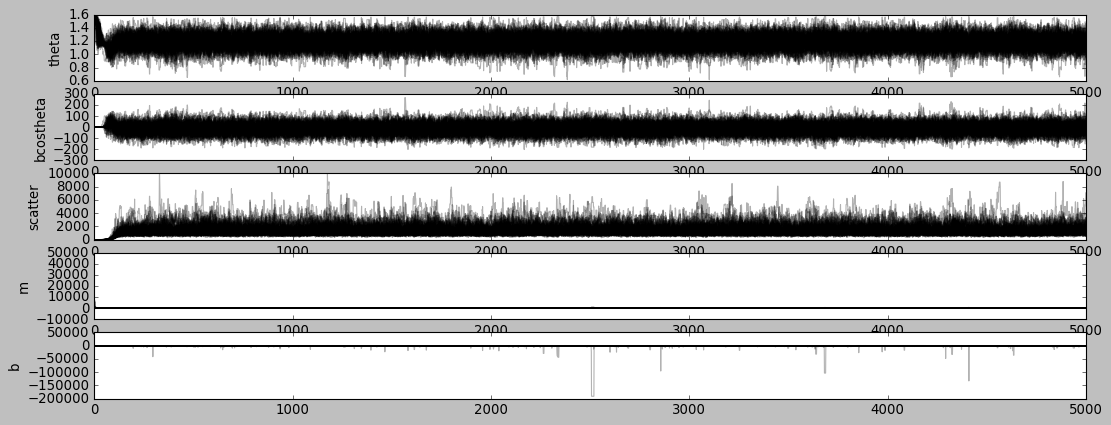

(4000, 100, 3)
(100,)
0 walkers did not converge
(400000, 3)


acceptance fraction is: 0.629672
m is 2.4686285877081042+0.9047441830916361-0.5537690744067492
b is -34.777329566938946+101.63046636858968-164.0096572407628
(400000, 3)


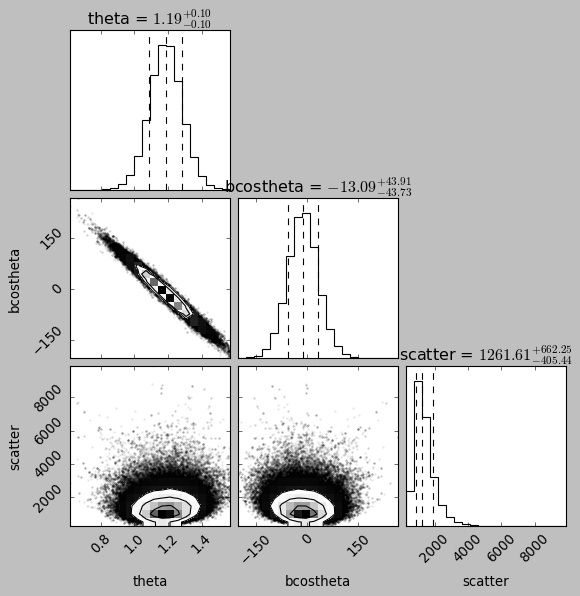

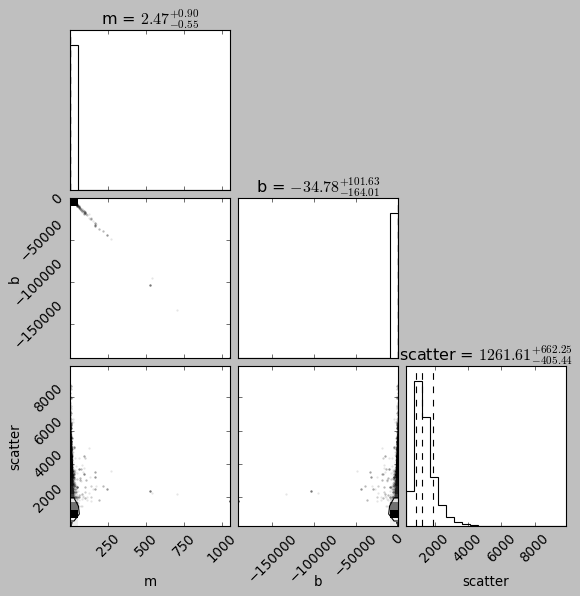

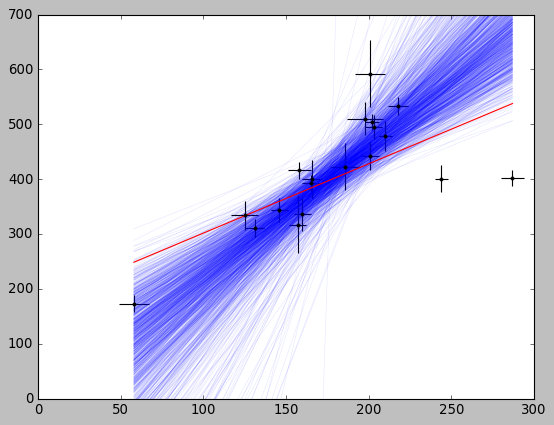

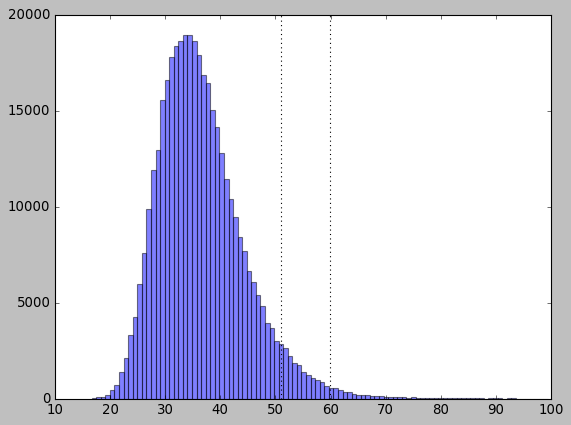

In [28]:
#full hogg+2010 data set
#x = np.array((201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146))
#y = np.array((592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344))
#yerr=np.array((61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22))
#xerr=np.array((9,4,11,7,5,9,4,4,11,7,5,5,5,6,6,5,9,8,6,5))
#exclude point 3
x = np.array((201,244,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146))
y = np.array((592,401,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344))
yerr=np.array((61,25,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22))
xerr=np.array((9,4,7,5,9,4,4,11,7,5,5,5,6,6,5,9,8,6,5))

xsort = np.argsort(x)
x = x[xsort]
y = y[xsort]
xerr = xerr[xsort]
yerr = yerr[xsort]

B, Bvar = least_squares_line(X=x, Y=y, Yerr=yerr)
                             
flat_lineparams, flat_lineparams_stats = fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi/2),bcostheta_bounds=(-500,500), scatter_bounds=(0,10000), nwalkers=100, nsteps=5000, discard=1000, plot=True,prune_unconverged_walkers=True)
median = flat_lineparams_stats[1]
upper = flat_lineparams_stats[2] - flat_lineparams_stats[1]
lower = flat_lineparams_stats[1] - flat_lineparams_stats[0]

print("m is {0}+{1}-{2}".format(median[0],upper[0],lower[0]))
print("b is {0}+{1}-{2}".format(median[1],upper[1],lower[1]))

print(np.shape(flat_lineparams))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(x,y,xerr=xerr, yerr=yerr, marker='.',color='k',ls='None',elinewidth=1,capsize=0)
rand_idxs = np.random.choice(len(flat_lineparams), 1000)
for i in rand_idxs:
    m = flat_lineparams[i][0]
    b = flat_lineparams[i][1]
    ax.plot(x, m*x + b, 'b-', lw=0.5, alpha=0.1)
ax.plot(x,B[0]*x + B[1],'r-')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(np.sqrt(flat_lineparams[:,2]),bins=100,color='b',alpha=0.5)
ax.axvline(np.percentile(np.sqrt(flat_lineparams[:,2]),95),color='k',ls=':')
ax.axvline(np.percentile(np.sqrt(flat_lineparams[:,2]),99),color='k',ls=':')
plt.show()

/Users/Emily/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


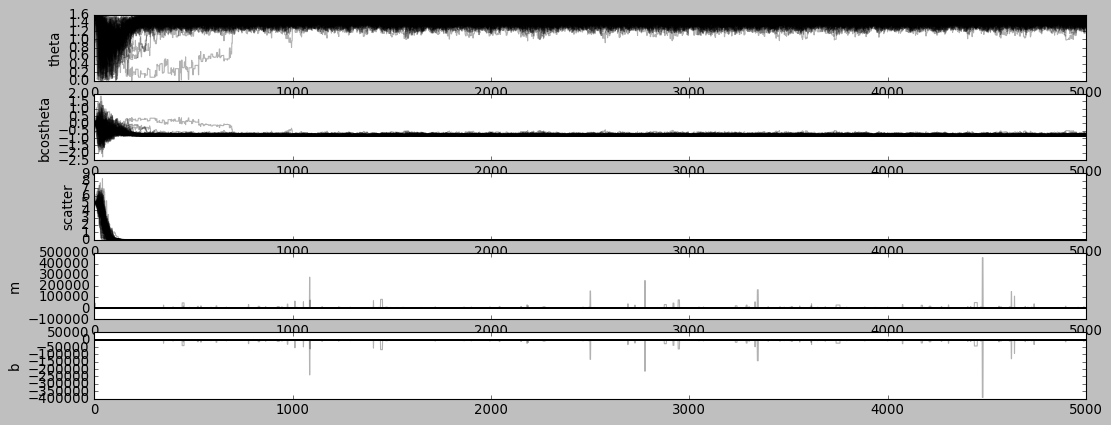

acceptance fraction is: 0.5986480000000001
m is 9.21248490235459+17.039768228021053-4.289966324574227
b is -7.462560797755101+3.6685516912580547-14.582127237001925
(450000, 3)


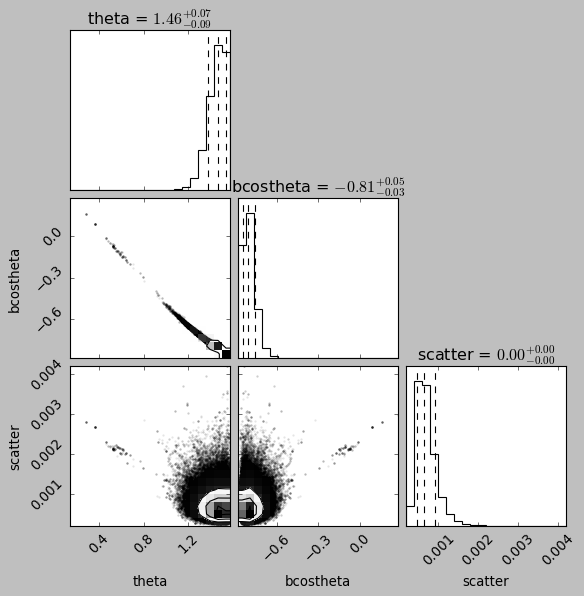

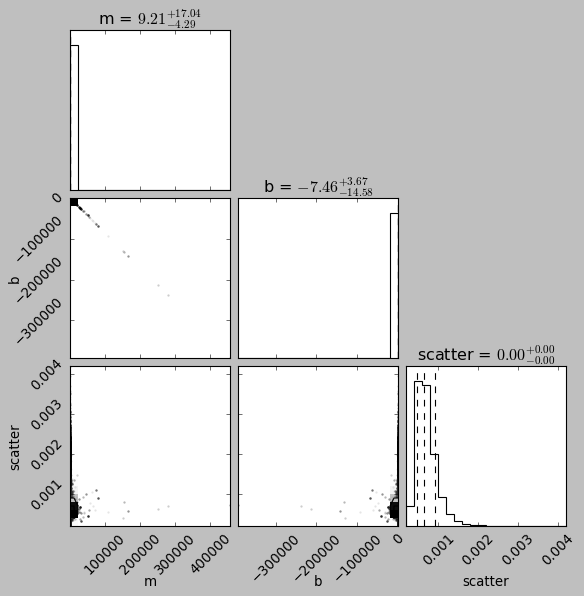

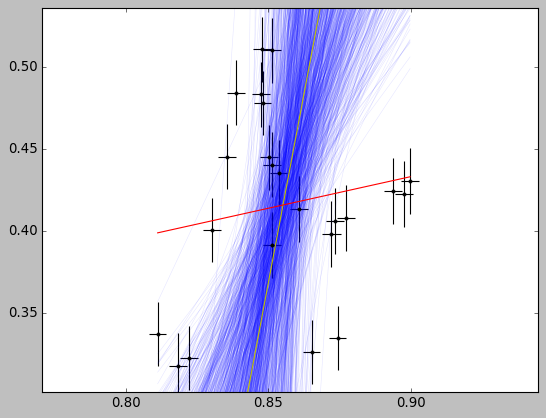

In [29]:

x=np.array((0.86518763, 0.8743743, 0.81822045, 0.82218872, 0.81113462, 0.83027826,0.85361794, 0.85127408, 0.84797507 ,0.84789921, 0.8513024,  0.84743741,0.8385715,  0.83562755, 0.85031074, 0.86085689, 0.87743239, 0.85130059,0.87219546, 0.87337987, 0.89755237, 0.89377721, 0.8998122))
xerr=np.array((0.00308979, 0.00309054, 0.00309107, 0.00309344, 0.0030939,  0.00309458,0.00309453, 0.00310294, 0.00310314, 0.00310372, 0.00310221, 0.00311039,0.00312605, 0.00312619, 0.00313617, 0.00318387, 0.00318387, 0.00318438,0.0031847,  0.0031846 , 0.00318502, 0.0031853,  0.00318601))
y=np.array((0.32588646, 0.33466758, 0.31762944, 0.32219925, 0.33673174, 0.40056889,0.43541787, 0.44035754, 0.47793995, 0.5106892,  0.51013362, 0.48327647,0.48416061, 0.44504003, 0.44477885, 0.4134431,  0.40795002, 0.39134517,0.39798322, 0.40580107, 0.42227752, 0.42434511, 0.4300923))
yerr=np.array((0.01958733, 0.01959682, 0.01960372, 0.0196076,  0.0196101,  0.01961367,0.01965205, 0.01969104, 0.01969406, 0.01969715, 0.01969935, 0.01972959,0.01983113, 0.01977631, 0.01988631, 0.02015853, 0.02016081, 0.02015399,0.02015579, 0.02016649, 0.02016726, 0.02016861, 0.02016564))
xsort = np.argsort(x)
x = x[xsort]
y = y[xsort]
xerr = xerr[xsort]
yerr = yerr[xsort]

B, Bvar = least_squares_line(X=x, Y=y, Yerr=yerr)
flat_lineparams, flat_lineparams_stats = fitMCMCline(x, y, xerr, yerr, theta_bounds=(0,np.pi/2),bcostheta_bounds=(-500,500), scatter_bounds=(0,10000),nwalkers=100, nsteps=5000, discard=500, plot=True)
median = flat_lineparams_stats[1]
upper = flat_lineparams_stats[2] - flat_lineparams_stats[1]
lower = flat_lineparams_stats[1] - flat_lineparams_stats[0]

print("m is {0}+{1}-{2}".format(median[0],upper[0],lower[0]))
print("b is {0}+{1}-{2}".format(median[1],upper[1],lower[1]))

print(np.shape(flat_lineparams))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(x,y,xerr=xerr, yerr=yerr, marker='.',color='k',ls='None',elinewidth=1,capsize=0)
rand_idxs = np.random.choice(len(flat_lineparams), 1000)
for i in rand_idxs:
    m = flat_lineparams[i][0]
    b = flat_lineparams[i][1]
    ax.plot(x, m*x + b, 'b-', lw=0.5, alpha=0.1)
ax.plot(x, flat_lineparams_stats[1][0]*x+flat_lineparams_stats[1][1],'y-')
ax.plot(x,B[0]*x + B[1],'r-')
ax.set_xlim(0.95*np.min(x),1.05*np.max(x))
ax.set_ylim(0.95*np.min(y),1.05*np.max(y))
plt.show()


In [30]:
# functions for fitting linear relationship between two EIT bands at a given bakeout segment
def medianBinEIT(tDaily, tEIT, fEIT, uEIT):
    binned_f, bin_edges, binnumber = binned_statistic(x=tEIT, values=fEIT, statistic='median', bins=tDaily)
    binned_u, bin_edges, binnumber = binned_statistic(x=tEIT, values=uEIT, statistic='mean', bins=tDaily)
    binned_u = np.sqrt((np.pi/2)*binned_u)
    return binned_f, binned_u


def fit2EITBakeoutSegment(t1, f1, u1, t2, f2, u2, t_start, t_end, theta_bounds=(0,np.pi), bcostheta_bounds=(-10,10), scatter_bounds=(0,10),nwalkers=10, nsteps=5000, discard=500, plotMCMC=False,plotFit=True, prune_unconverged_walkers=True):
    """
    t_start = start of bakeout segment [JD]
    t_end = end of bakeout segment[JD]
    """
    
    t1daily = np.arange(np.floor(t1[0]),np.ceil(t1[-1])+1,1)
    binned_f1, binned_u1 = medianBinEIT(tDaily=t1daily,tEIT=t1,fEIT=f1,uEIT=u1)

    t2daily = np.arange(np.floor(t2[0]),np.ceil(t2[-1])+1,1)
    binned_f2, binned_u2 = medianBinEIT(tDaily=t2daily,tEIT=t2,fEIT=f2,uEIT=u2)

    binned_t1 = 0.5*(t1daily[0:-1] + t1daily[1:])
    binned_t2 = 0.5*(t2daily[0:-1] + t2daily[1:])
    
    f1med = np.median(f1[~np.isnan(f1)])
    f2med = np.median(f2[~np.isnan(f2)])
    
    norm_f1 = binned_f1/f1med
    norm_u1 = binned_u1/f1med
    norm_f2 = binned_f2/f2med
    norm_u2 = binned_u2/f2med

    nonans1 = ~np.isnan(binned_t1) & ~np.isnan(norm_f1) & ~np.isnan(norm_u1)
    nonans2 = ~np.isnan(binned_t2) & ~np.isnan(norm_f2) & ~np.isnan(norm_u2)

    binned_t1=binned_t1[nonans1]
    norm_f1=norm_f1[nonans1]
    norm_u1=norm_u1[nonans1]
    
    binned_t2=binned_t2[nonans2]
    norm_f2=norm_f2[nonans2]
    norm_u2=norm_u2[nonans2]

    # overlap_t == binned_t1[binned_t1_ind_at_common_obstimes] == binned_t2[binned_t2_ind_at_common_obstimes]
    overlap_t, binned_t1_ind_at_common_obstimes, binned_t2_ind_at_common_obstimes = np.intersect1d(np.round(binned_t1,0), np.round(binned_t2,0), return_indices=True)
    
    bakeout_segment_mask = (overlap_t >= t_start) & (overlap_t < t_end)

    x_to_fit = norm_f1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    xerr_to_fit = norm_u1[binned_t1_ind_at_common_obstimes][bakeout_segment_mask]
    
    y_to_fit = norm_f2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    yerr_to_fit = norm_u2[binned_t2_ind_at_common_obstimes][bakeout_segment_mask]
    
    if len(x_to_fit) < 2:
        print("not enough data in this segment")
        return None, None

    else:
        xsort = np.argsort(x_to_fit)
        x_to_fit = x_to_fit[xsort]
        y_to_fit = y_to_fit[xsort]
        xerr_to_fit = xerr_to_fit[xsort]
        yerr_to_fit = yerr_to_fit[xsort]

        flat_lineparams, flat_lineparams_stats = fitMCMCline(x=x_to_fit, y=y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit, theta_bounds=theta_bounds,bcostheta_bounds=bcostheta_bounds, scatter_bounds=scatter_bounds,nwalkers=nwalkers, nsteps=nsteps, discard=discard, plot=plotMCMC,prune_unconverged_walkers=prune_unconverged_walkers)
    
        if plotFit is True:
            B, Bvar = least_squares_line(X=x_to_fit, Y=y_to_fit, Yerr=yerr_to_fit)
    
            fig, ax = plt.subplots(1,1,figsize=(4,4))
            ax.errorbar(x_to_fit, y_to_fit, xerr=xerr_to_fit, yerr=yerr_to_fit,color='k', marker='.',linestyle='None', elinewidth=1, capsize=0,zorder=1)

            rand_idxs = np.random.choice(len(flat_lineparams), 1000)
            for i in rand_idxs:
                ax.plot(x_to_fit, flat_lineparams[i][0]*x_to_fit + flat_lineparams[i][1],'b-',lw=1,alpha=0.1,zorder=0)
            
            ax.plot(x_to_fit,B[0]*x_to_fit + B[1],'r-',zorder=2)

            ax.set_xlim(np.min(x_to_fit)*0.95, np.max(x_to_fit)*1.05)
            ax.set_ylim(np.min(y_to_fit)*0.95, np.max(y_to_fit)*1.05)
            plt.show()
    
    
        return flat_lineparams, flat_lineparams_stats


# Now, fit linear relationships between the four EIT bands.

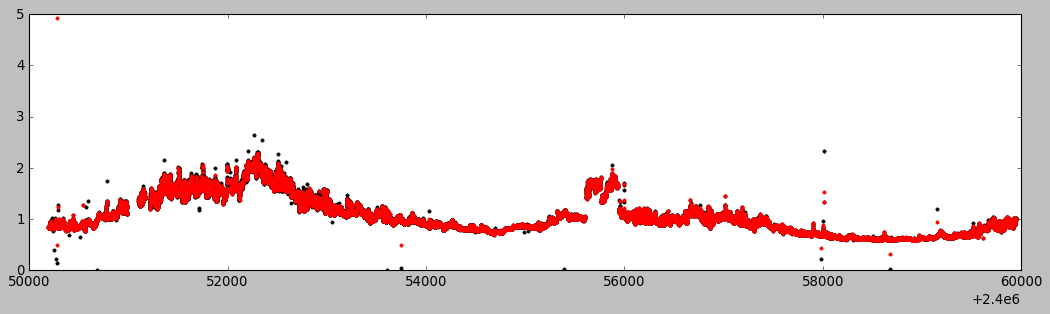

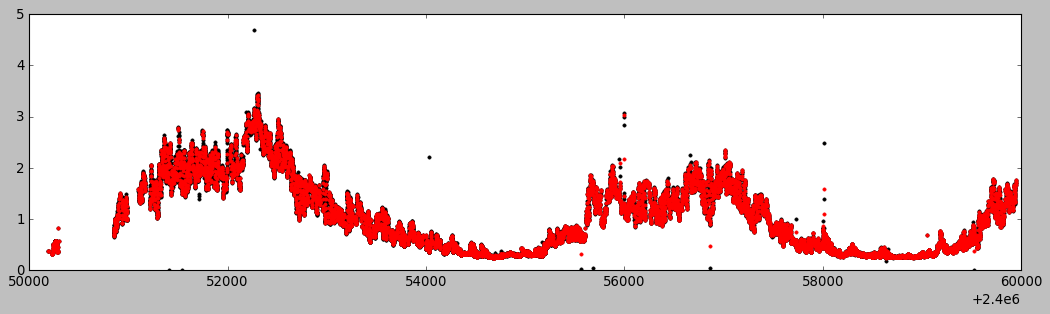

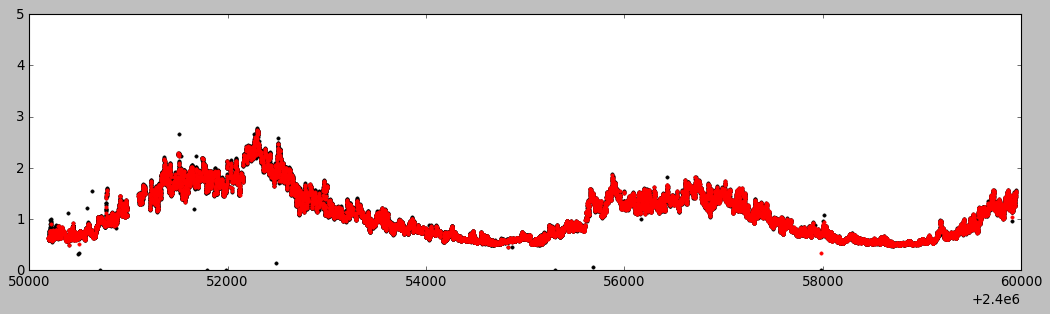

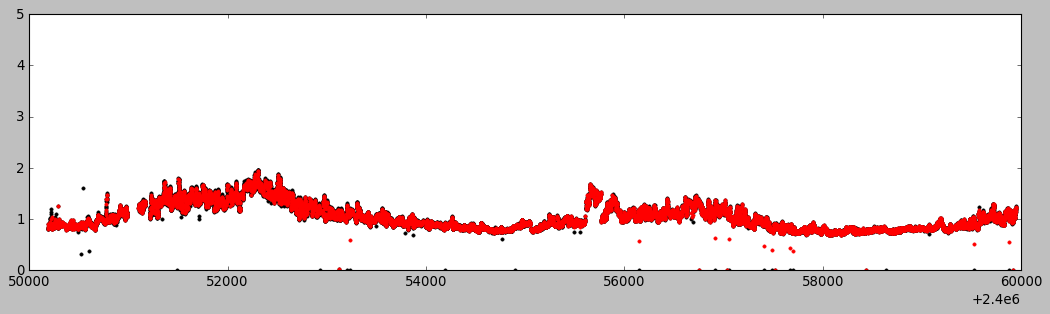

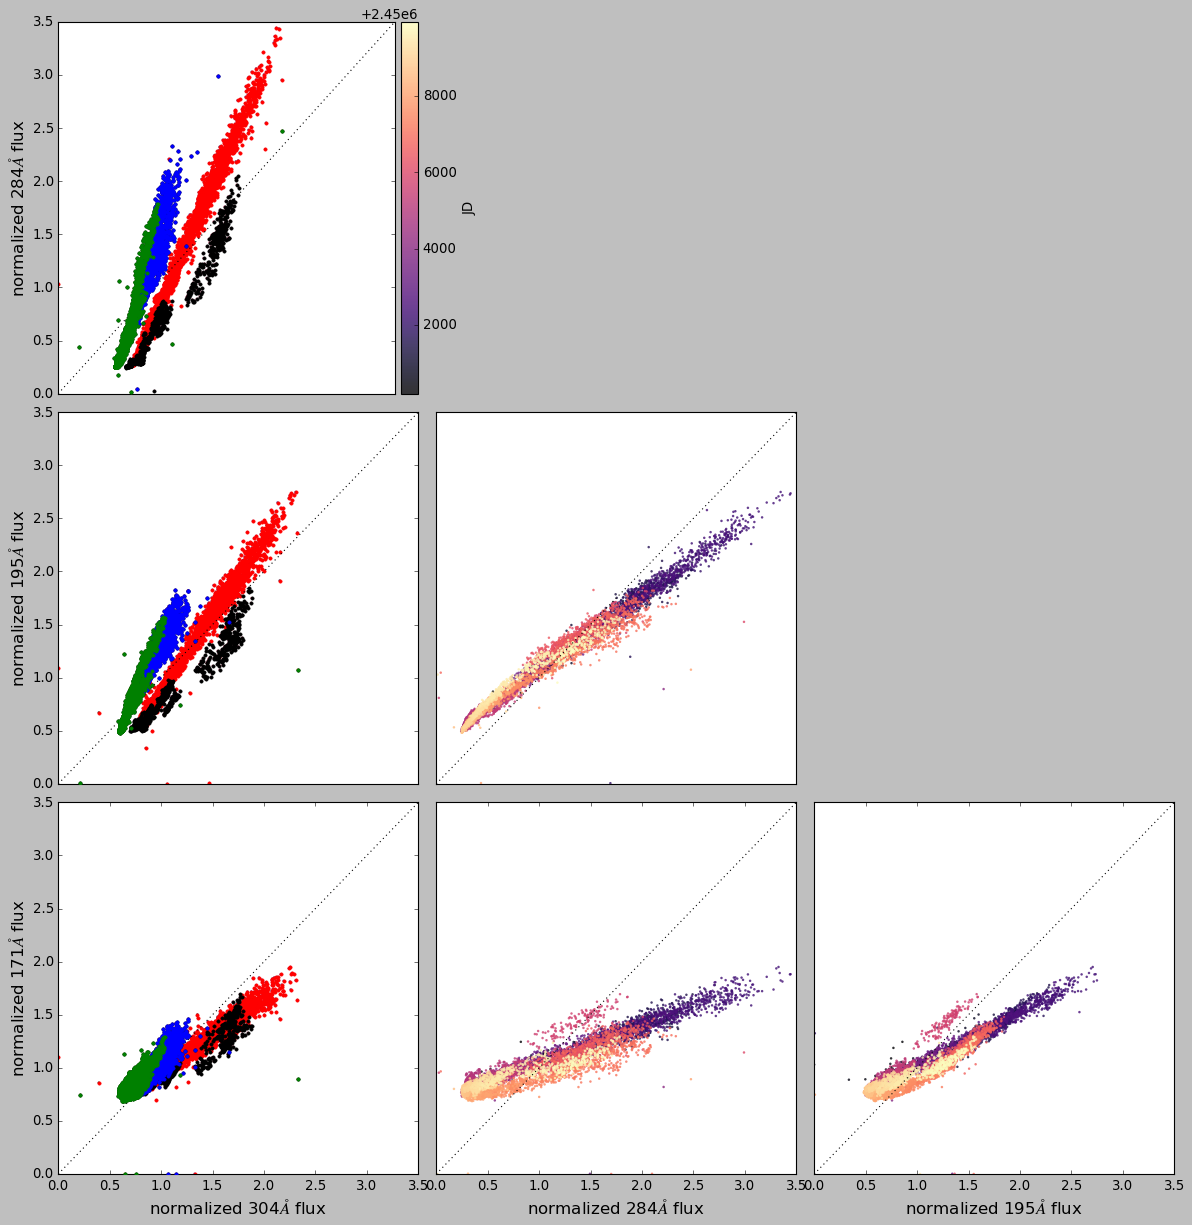

In [31]:
fArrs_to_plot = [f304_expCorrected, f284, f195, f171]
uArrs_to_plot = [u304_expCorrected, u284, u195, u171]
#fArrs_to_plot = [f304_corrected_all, f284, f195, f171]
#uArrs_to_plot = [u304_corrected_all, u284, u195, u171]
tArrs_to_plot = [t304, t284, t195, t171]

for i in range(4):
    tDaily = np.arange(np.floor(tArrs_to_plot[i][0]),np.ceil(tArrs_to_plot[i][-1])+1,1)
    binned_f, binned_u = medianBinEIT(tDaily=tDaily,tEIT=tArrs_to_plot[i],fEIT=fArrs_to_plot[i],uEIT=uArrs_to_plot[i])

    fmed = np.median(fArrs_to_plot[i])
    fig, ax = plt.subplots(1,1,figsize=(16,4))
    ax.errorbar(tArrs_to_plot[i],fArrs_to_plot[i]/fmed,yerr=uArrs_to_plot[i]/fmed,color='k',marker='.',ls='None',elinewidth=1,capsize=0,zorder=1)
    ax.errorbar(0.5*(tDaily[0:-1]+tDaily[1:]),binned_f/fmed,yerr=binned_u/fmed,color='r',marker='.',ls='None',elinewidth=1,capsize=0,zorder=2)

    ax.set_ylim(0,5)
    plt.show()


# may 22, 2008 (first bakeout with obvious discontinuity)
tsplit_1 = 2454609.072650

# beginning of f304 first exponential trend
tsplit_exp1 = 2455938.417
# beginning of f304 second exponential trend
tsplit_exp2 = 2457542.583333

fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[0],0), return_indices=True)

    split0 = (overlap_t <= tsplit_1)
    split1 = (overlap_t > tsplit_1)
    split_exp1 = (overlap_t > tsplit_exp1) & (overlap_t <= tsplit_exp2)
    split_exp2 = (overlap_t > tsplit_exp2)
    
    c_s = axes[i-1,0].scatter(fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[0][t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8,zorder=0)
    
    axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split0]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split0]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'r.',zorder=1)
    axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'k.',zorder=2)
    axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp1]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp1]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'b.',zorder=3)
    axes[i-1,0].plot(fArrs_to_plot[0][t304_ind][split_exp2]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])]), fArrs_to_plot[i][tEIT_i_ind][split_exp2]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), 'g.',zorder=4)
    
   
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    overlap_t, tEIT_i_ind, t284_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[1],0), return_indices=True)
    
    axes[i-1,1].scatter(fArrs_to_plot[1][t284_ind]/np.median(fArrs_to_plot[1][~np.isnan(fArrs_to_plot[1])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[1][t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    overlap_t, tEIT_i_ind, t195_ind = np.intersect1d(np.round(tArrs_to_plot[i],0), np.round(tArrs_to_plot[2],0), return_indices=True)
    
    axes[i-1,2].scatter(fArrs_to_plot[2][t195_ind]/np.median(fArrs_to_plot[2][~np.isnan(fArrs_to_plot[2])]), fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])]), c=tArrs_to_plot[2][t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)

    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(5),np.arange(5),color='k',ls=':')

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])

plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()
#plt.savefig("./ratio_EITbands_to_eachother_expCorrected.pdf",bbox_inches="tight")
#plt.savefig("./ratio_EITbands_to_eachother_corrected.pdf",bbox_inches="tight")

/Users/Emily/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


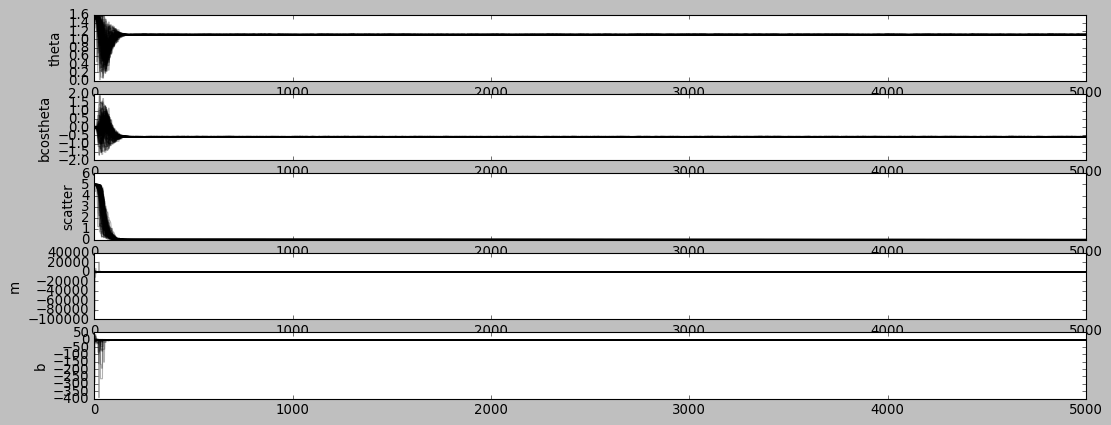

(2000, 100, 3)
(100,)
0 walkers did not converge
(200000, 3)
acceptance fraction is: 0.638246


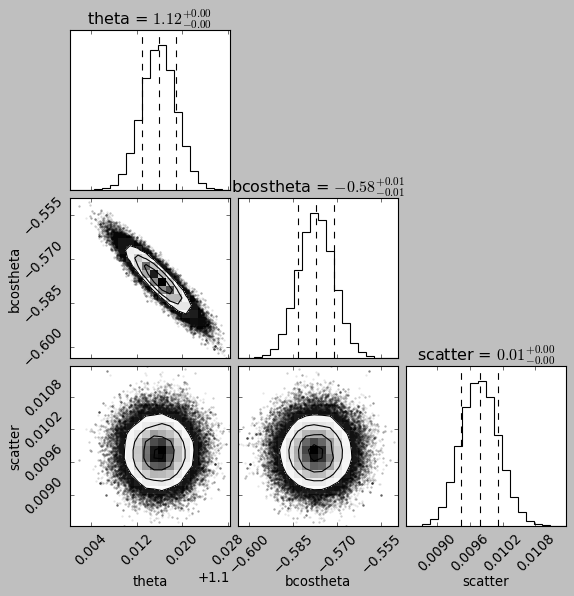

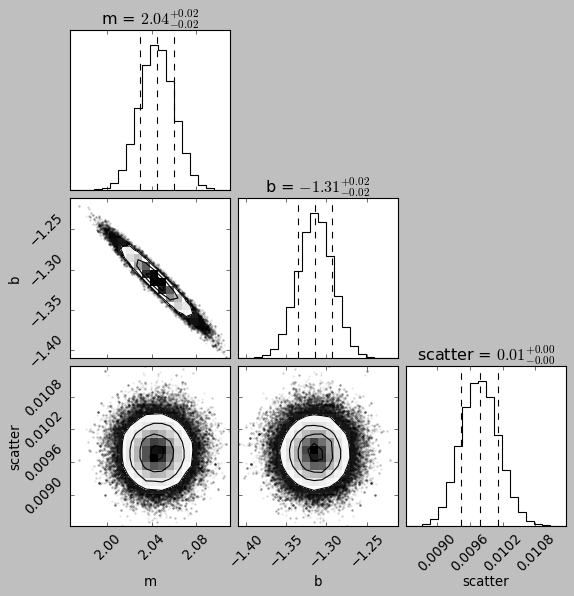

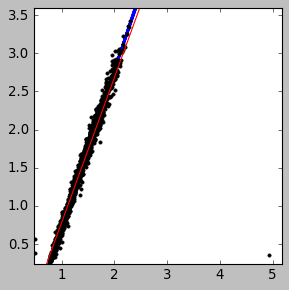

/Users/Emily/anaconda3/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


emcee: Exception while calling your likelihood function:
  params: [ 0.95398063 -0.30276273  0.00753437]
  args: [array([0.49673359, 0.49832303, 0.7583202 , ..., 2.27567951, 2.29675008,
       4.92639087]), array([0.65500163, 0.79372218, 0.52544423, ..., 2.69967622, 2.72229921,
       0.62729926]), array([1.23351085e-05, 1.20060999e-05, 1.17774995e-05, ...,
       1.19185086e-05, 1.19198260e-05, 1.37691603e-05]), array([7.39932651e-06, 7.21547602e-06, 7.17392735e-06, ...,
       7.20374685e-06, 7.20531530e-06, 7.38645378e-06]), (0, 1.5707963267948966), (-10, 10), (0, 5)]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/Emily/anaconda3/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_21974/3104176461.py", line 134, in log_posterior
    likelihood = log_likelihood(params, x, y, xerr, yerr, xycov)
  File "/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_21974/3104176461.py", line 116, in log_likelihood
    ll = -np.sum(0.5*np.log(sigma_sq+scatter)) - np.sum( delta_arr**2/(2*(sigma_sq+scatter)) )
KeyboardInterrupt


KeyboardInterrupt: 

In [32]:
# before May 22, 2008 (first obvious bakeout discontinuity)
tstart = t304[0]
tend = 2454609.072650

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

for j in range(54,80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']
    print(tstart)
    lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
    lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
    lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

#final segment, after all bakeouts
tstart = heaterOff[-1]['jd']
tend = t304[-1]

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5),nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)


(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.6308399999999998
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.62348
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.5144
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.56018
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.41328000000000004
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.62814
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.62364
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.6294799999999999
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.6278
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance fraction is: 0.62978
(2000, 10, 3)
(10,)
0 walkers did not converge
(20000, 3)
acceptance

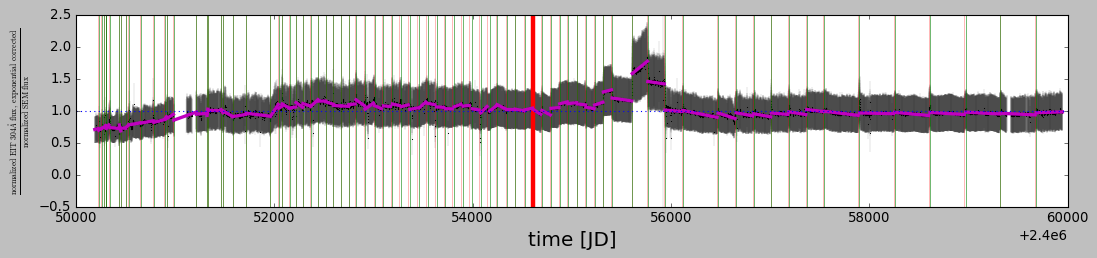

In [74]:
# new arrays to work with
f304_corrected_all = copy.deepcopy(f304_expCorrected)
u304_corrected_all = copy.deepcopy(u304_expCorrected)
f284_corrected_all = copy.deepcopy(f284)
#u284_corrected_all = copy.deepcopy(u284)
#f195_corrected_all = copy.deepcopy(f195)
#u195_corrected_all = copy.deepcopy(u195)
#f171_corrected_all = copy.deepcopy(f171)
#u171_corrected_all = copy.deepcopy(u171)

f304_corrected_2008onwards = copy.deepcopy(f304_expCorrected)
u304_corrected_2008onwards = copy.deepcopy(u304_expCorrected)
f284_corrected_2008onwards = copy.deepcopy(f284)
#u284_corrected_2008onwards = copy.deepcopy(u284)
#f195_corrected_2008onwards = copy.deepcopy(f195)
#u195_corrected_2008onwards = copy.deepcopy(u195)
#f171_corrected_2008onwards = copy.deepcopy(f171)
#u171_corrected_2008onwards = copy.deepcopy(u171)


#outlier rejection
unc_ratio_expCorrected[ratio_expCorrected  < 0.5] = np.nan
ratio_expCorrected[ratio_expCorrected < 0.5] = np.nan

# plot linear fits as we go
fig, ax = plt.subplots(1,1,figsize=(16,3))

ax.errorbar(tSEM[t304_mask], ratio_expCorrected, yerr=unc_ratio_expCorrected, color='k', elinewidth=0.1,capsize=0,marker='.',linestyle="None",ms=1,zorder=1)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']
    ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5,zorder=1,alpha=0.5)
    ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5,zorder=2,alpha=1)

ax.axvline(2454609.072650, color='r', lw=4)

ax.set_ylim(-0.5,2.5)
ax.set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ exponential\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
ax.set_xlabel(r"time [JD]", fontsize=18)

#first segment, before any bakeouts
# pre-2008, use one single linear fit to relate different EIT bands
tstart = t304[0]
tend = 2454609.072650
lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=10, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)
#lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
#lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

m284 = lpstats_284_vs_304[1][0]
m284_unc = 0.5*(lpstats_284_vs_304[0][0] + lpstats_284_vs_304[2][0])
b284 = lpstats_284_vs_304[1][1]
b284_unc = 0.5*(lpstats_284_vs_304[0][1] + lpstats_284_vs_304[2][1])

fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=tSEM[t304_mask][0], next_bakeoutStartDate=heaterOn[0]['jd'])

ax.plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=2)

fitMask_t304 = (t304 >= t304[0]) & (t304 <= heaterOn[0]['jd']) 
fitMask_t284 = (t284 >= t304[0]) & (t284 <= heaterOn[0]['jd']) 

fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
f304_corrected_all[fitMask_t304] = fcorr
u304_corrected_all[fitMask_t304] = ucorr 

f284_linearPrediction = m284*(f304_expCorrected[fitMask_t304]/np.median(f304_expCorrected)) + b284
# we want to divide this out from f284[fitMask_284], but it doesn't have the same length
f284_linearPrediction_t284, uplaceholder = linearInterpolationWithUncertainty(t_new=t284[fitMask_t284], t_orig=t304[fitMask_t304], f_orig=f284_linearPrediction, u_orig=np.ones_like(f284_linearPrediction))

f284_corrected_all[fitMask_t284] = f284[fitMask_t284]/f284_linearPrediction_t284

for j in range(80):
    tstart = heaterOff[j]['jd']
    tend = heaterOn[j+1]['jd']
    
    fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[j]['jd'], next_bakeoutStartDate=heaterOn[j+1]['jd'])

    ax.plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=2)
    
    fitMask_t304 = (t304 >= heaterOff[j]['jd']) & (t304 <= heaterOn[j+1]['jd']) 
    fitMask_t284 = (t284 >= heaterOff[j]['jd']) & (t284 <= heaterOn[j+1]['jd']) 
    fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
    f304_corrected_all[fitMask_t304] = fcorr
    u304_corrected_all[fitMask_t304] = ucorr 
    
    if heaterOff[j]['jd'] < 2454609.072650:
        f284_linearPrediction = m284*(f304_expCorrected[fitMask_t304]/np.median(f304_expCorrected)) + b284
        # we want to divide this out from f284[fitMask_284], but it doesn't have the same length
        f284_linearPrediction_t284, uplaceholder = linearInterpolationWithUncertainty(t_new=t284[fitMask_t284], t_orig=t304[fitMask_t304], f_orig=f284_linearPrediction, u_orig=np.ones_like(f284_linearPrediction))
        f284_corrected_all[fitMask_t284] = f284[fitMask_t284]/f284_linearPrediction_t284

    # May 22, 2008 (first bakeout with obvious discontinuity)
    if heaterOff[j]['jd'] >= 2454609.072650:
        f304_corrected_2008onwards[fitMask_t304] = fcorr
        u304_corrected_2008onwards[fitMask_t304] = ucorr

        lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=10, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)
        #lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
        #lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

        m284 = lpstats_284_vs_304[1][0]
        m284_unc = 0.5*(lpstats_284_vs_304[0][0] + lpstats_284_vs_304[2][0])
        b284 = lpstats_284_vs_304[1][1]
        b284_unc = 0.5*(lpstats_284_vs_304[0][1] + lpstats_284_vs_304[2][1])

        f284_linearPrediction = m284*(f304_expCorrected[fitMask_t304]/np.median(f304_expCorrected)) + b284
        # we want to divide this out from f284[fitMask_284], but it doesn't have the same length
        f284_linearPrediction_t284, uplaceholder = linearInterpolationWithUncertainty(t_new=t284[fitMask_t284], t_orig=t304[fitMask_t304], f_orig=f284_linearPrediction, u_orig=np.ones_like(f284_linearPrediction))
        f284_corrected_all[fitMask_t284] = f284[fitMask_t284]/f284_linearPrediction_t284




        
    
#final segment, after all bakeouts
tstart = heaterOff[-1]['jd']
tend = t304[-1]

fitMask, B, Bunc = fitBakeoutSegment(t=tSEM[t304_mask], ratio=ratio_expCorrected, unc_ratio=unc_ratio_expCorrected, prev_bakeoutEndDate=heaterOff[-1]['jd'], next_bakeoutStartDate=tSEM[t304_mask][-1])

ax.plot(tSEM[t304_mask][fitMask], B[0]*(tSEM[t304_mask][fitMask] - tSEM[t304_mask][fitMask][0]) + B[1], 'm-',lw=3,zorder=2)

lp_284_vs_304, lpstats_284_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t284, f2=f284, u2=u284, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=10, nsteps=5000, discard=3000, plotMCMC=False,plotFit=False, prune_unconverged_walkers=True)
#lp_195_vs_304, lpstats_195_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t195, f2=f195, u2=u195, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)
#lp_171_vs_304, lpstats_171_vs_304 = fit2EITBakeoutSegment(t1=t304, f1=f304_expCorrected, u1=u304_expCorrected, t2=t171, f2=f171, u2=u171, t_start=tstart, t_end=tend, theta_bounds=(0,np.pi/2), bcostheta_bounds=(-10,10), scatter_bounds=(0,5), nwalkers=100, nsteps=5000, discard=3000, plotMCMC=True,plotFit=True, prune_unconverged_walkers=True)

m284 = lpstats_284_vs_304[1][0]
m284_unc = 0.5*(lpstats_284_vs_304[0][0] + lpstats_284_vs_304[2][0])
b284 = lpstats_284_vs_304[1][1]
b284_unc = 0.5*(lpstats_284_vs_304[0][1] + lpstats_284_vs_304[2][1])

fitMask_t304 = (t304 >= heaterOff[-1]['jd']) & (t304 <= t304[-1]) 
fitMask_t284 = (t284 >= heaterOff[-1]['jd']) & (t284 <= t304[-1]) 

fcorr, ucorr = correctLinearBakeoutSegment(t304[fitMask_t304]- t304[fitMask_t304][0], f304_expCorrected[fitMask_t304], u304_expCorrected[fitMask_t304], B, Bunc)
f304_corrected_all[fitMask_t304] = fcorr
u304_corrected_all[fitMask_t304] = ucorr 
f304_corrected_2008onwards[fitMask_t304] = fcorr
u304_corrected_2008onwards[fitMask_t304] = ucorr

f284_linearPrediction = m284*(f304_expCorrected[fitMask_t304]/np.median(f304_expCorrected)) + b284
# we want to divide this out from f284[fitMask_284], but it doesn't have the same length
f284_linearPrediction_t284, uplaceholder = linearInterpolationWithUncertainty(t_new=t284[fitMask_t284], t_orig=t304[fitMask_t304], f_orig=f284_linearPrediction, u_orig=np.ones_like(f284_linearPrediction))
f284_corrected_all[fitMask_t284] = f284[fitMask_t284]/f284_linearPrediction_t284


ax.axhline(1,linestyle=':')
#ax.set_xlim(2454000,2456000)
plt.show()


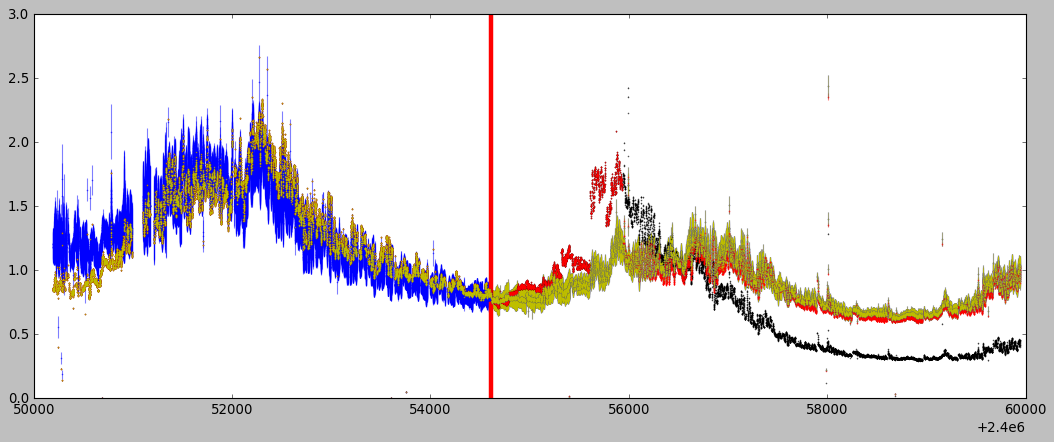

In [75]:
norm = np.median(f304[~np.isnan(f304)])

fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t304, f304/norm, u304/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_expCorrected/norm, u304_expCorrected/norm, color='r',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_corrected_all/norm, u304_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.errorbar(t304, f304_corrected_2008onwards/norm, u304_corrected_2008onwards/norm, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.axvline(2454609.072650, color='r', lw=4)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,3)
plt.show()

5158691.155804405


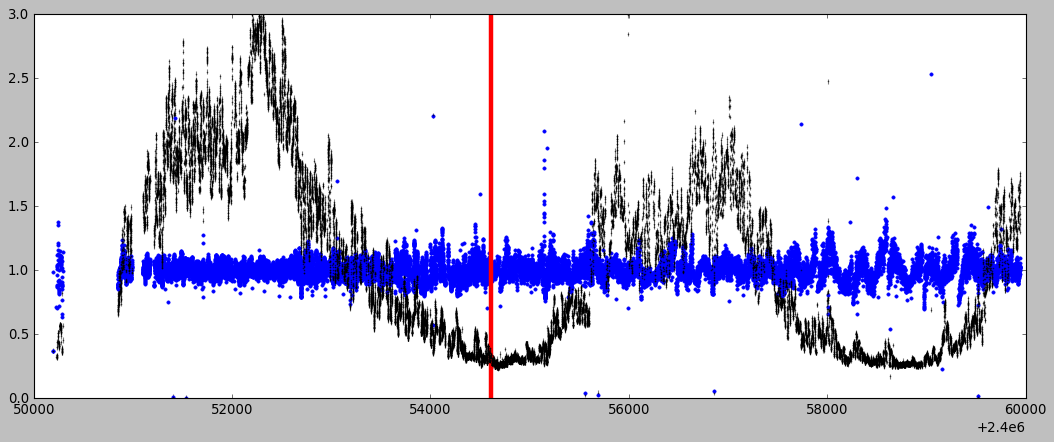

In [76]:
norm = np.median(f284[~np.isnan(f284)])
print(norm)
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.errorbar(t284, f284/norm, u284/norm, color='k',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.plot(t284, f284_corrected_all/norm, 'b.')#u304_corrected_all/norm, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,alpha=0.5)
ax.axvline(2454609.072650, color='r', lw=4)
#ax.set_ylim(0.,1.e8)
ax.set_ylim(0.,3)
plt.show()


In [77]:
print(np.median(f284_corrected_all))

5162231.279138149


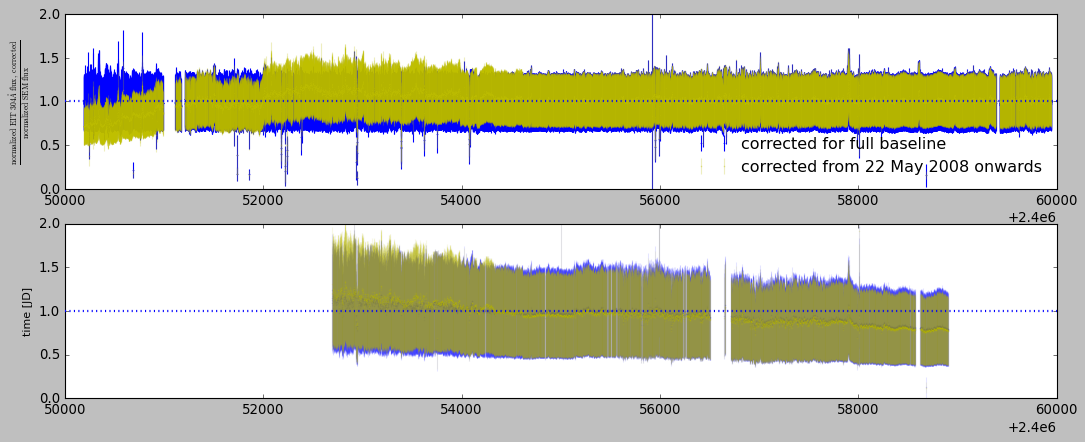

In [29]:
# Plot ratio of corrected 304 to SEM and SORCE.

f304_corrected_all_tSEM, u304_corrected_all_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_corrected_all, u_orig=u304_corrected_all)
f304_corrected_2008onwards_tSEM, u304_corrected_2008onwards_tSEM = linearInterpolationWithUncertainty(t_new=tSEM[t304_mask], t_orig=t304, f_orig=f304_corrected_2008onwards, u_orig=u304_corrected_2008onwards)

ratio_corrected_all, unc_ratio_corrected_all = normalizedFluxRatio(f1=f304_corrected_all_tSEM, f2=fSEM[t304_mask], u1=u304_corrected_all_tSEM, u2=uSEM[t304_mask])
ratio_corrected_2008onwards, unc_ratio_corrected_2008onwards = normalizedFluxRatio(f1=f304_corrected_2008onwards_tSEM, f2=fSEM[t304_mask], u1=u304_corrected_2008onwards_tSEM, u2=uSEM[t304_mask])

fig, axes = plt.subplots(2,1,figsize=(16,6))


axes[0].errorbar(tSEM[t304_mask], ratio_corrected_all, unc_ratio_corrected_all, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=1,label='corrected for full baseline')
axes[0].errorbar(tSEM[t304_mask], ratio_corrected_2008onwards, unc_ratio_corrected_2008onwards, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=2,alpha=0.25,label='corrected from 22 May 2008 onwards')
axes[0].set_ylim(0.,3)

f304_corrected_all_tSORCE, u304_corrected_all_tSORCE = linearInterpolationWithUncertainty(t_new=tSORCE, t_orig=t304, f_orig=f304_corrected_all, u_orig=u304_corrected_all)
f304_corrected_2008onwards_tSORCE, u304_corrected_2008onwards_tSORCE = linearInterpolationWithUncertainty(t_new=tSORCE, t_orig=t304, f_orig=f304_corrected_2008onwards, u_orig=u304_corrected_2008onwards)

med_sorce = np.median(fSORCE[~np.isnan(fSORCE)])

sorce_ratio_corrected_all, unc_sorce_ratio_corrected_all = normalizedFluxRatio(f2=fSORCE, f1=f304_corrected_all_tSORCE, u2=uSORCE, u1=u304_corrected_all_tSORCE)
sorce_ratio_corrected_2008onwards, unc_sorce_ratio_corrected_2008onwards = normalizedFluxRatio(f2=fSORCE, f1=f304_corrected_2008onwards_tSORCE, u2=uSORCE, u1=u304_corrected_2008onwards_tSORCE)

axes[1].errorbar(tSORCE, sorce_ratio_corrected_all, unc_sorce_ratio_corrected_all, color='b',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=1,alpha=0.1)
axes[1].errorbar(tSORCE, sorce_ratio_corrected_2008onwards, unc_sorce_ratio_corrected_2008onwards, color='y',marker='.',markersize=2,linestyle='None',elinewidth=1,capsize=0,zorder=2,alpha=0.1)

for ax in axes:
    ax.set_ylim(0.,2.,)
    ax.axhline(1, linestyle=":",lw=2,zorder=3)
    ax.set_xlim(2450000,2460000)

axes[0].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SEM\ flux}}$",fontsize=10)
axes[1].set_ylabel(r"$\frac{\mathrm{normalized\ EIT}\ 304\AA\ \mathrm{flux,\ corrected}}{\mathrm{normalized\ SORCE\ flux}}$",fontsize=10)
axes[1].set_ylabel("time [JD]")
axes[0].legend(loc='lower right',frameon=False)
plt.show()

## ratio of each other band to corrected 304

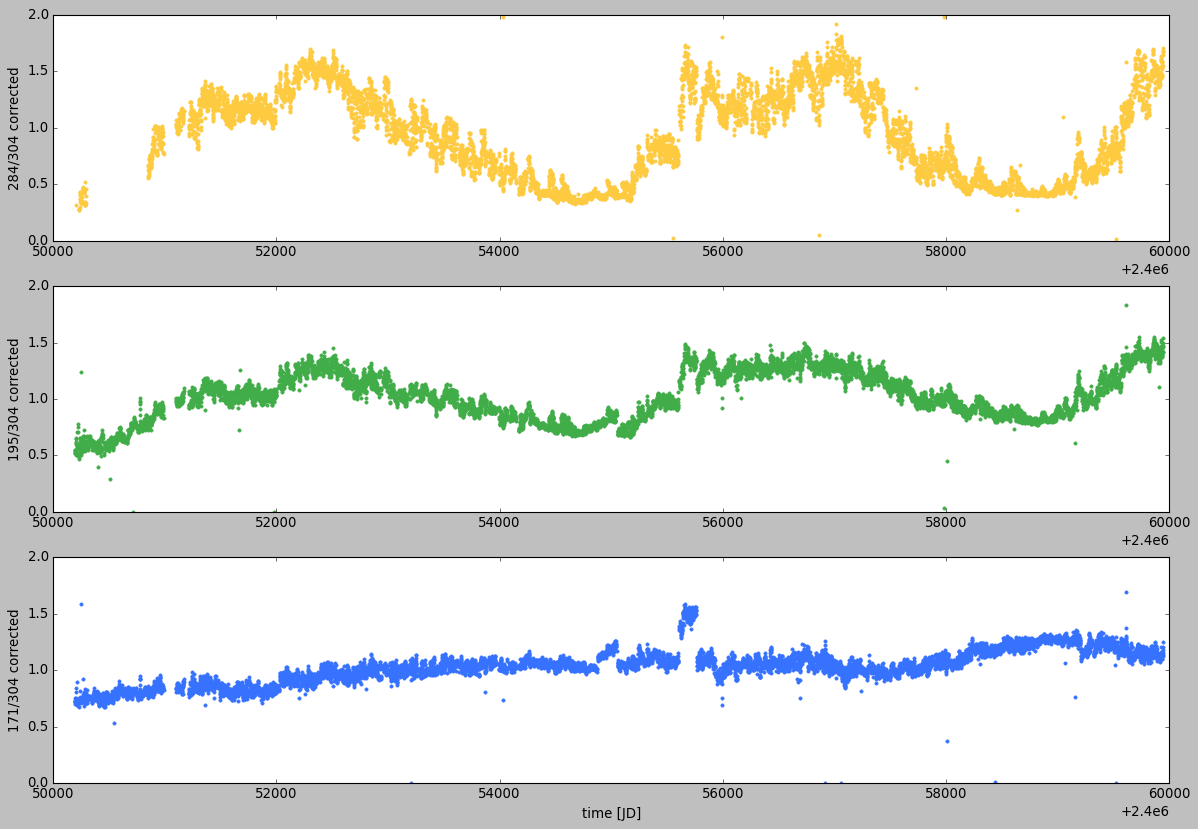

In [42]:

fig, axes = plt.subplots(3,1,figsize=(18,12))

for i in range(1,4):

    overlap_t, tEIT_i_ind, t304_ind = interpolate_two_EIT_ts(tArrs_to_plot[i], tArrs_to_plot[0])

    f304_norm = fArrs_to_plot[0][t304_ind]/np.median(fArrs_to_plot[0][~np.isnan(fArrs_to_plot[0])])
    fEIT_norm = fArrs_to_plot[i][tEIT_i_ind]/np.median(fArrs_to_plot[i][~np.isnan(fArrs_to_plot[i])])
    
    axes[i-1].plot(t304[t304_ind],fEIT_norm/f304_norm,color=cs[i],marker='.',ls='None') 
    axes[i-1].set_ylim(0,2)
    axes[i-1].set_ylabel("{0}/304 corrected".format(labels[i]))

axes[2].set_xlabel('time [JD]')
   
#plt.show()
plt.savefig("./ratio_EITbands_to_EIT304corrected.pdf",bbox_inches="tight")